In [ ]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (set

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [1]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
import glob


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns

# torch geometrics

import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN

import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader

from sklearn.metrics import roc_auc_score

2024-11-15 16:58:13.698366: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 16:58:15.889839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-15 16:58:18.522860: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/khushboo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Load graph
view=3
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/home/khushboo/VIEW3/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [4]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [5]:
nodes_df

,name,type
0,<http://purl.obolibrary.org/obo/HP_0010945>,Phenotype
1,<https://www.mirbase.org/mature/MIMAT0027026>,miRNA
2,<http://purl.obolibrary.org/obo/MONDO_0000996>,Disease
3,<http://purl.obolibrary.org/obo/UBERON_0003831>,Anatomy
4,<https://www.mirbase.org/hairpin/MI0031521>,miRNA
...,...,...
87352,<http://purl.obolibrary.org/obo/MONDO_0021636>,Disease
87353,<http://purl.obolibrary.org/obo/MONDO_0012749>,Disease
87354,<http://www.ncbi.nlm.nih.gov/gene/80099>,Gene
87355,<http://purl.obolibrary.org/obo/HP_0100788>,Phenotype


In [18]:
edges_df

,subject,predicate,object,type
0,<https://www.mirbase.org/mature/MIMAT0019020>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/5315>,Involved in regulation of
1,<https://www.mirbase.org/mature/MIMAT0000722>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0005061>,Causes or contributes to condition
2,<https://www.mirbase.org/mature/MIMAT0005869>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/6683>,Involved in regulation of
3,<https://www.mirbase.org/mature/MIMAT0004482>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/1829>,Involved in regulation of
4,<https://www.mirbase.org/mature/MIMAT0002822>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/5272>,Involved in regulation of
...,...,...,...,...
1699107,<https://www.mirbase.org/mature/MIMAT0014987>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/7227>,Involved in regulation of
1699108,<https://www.mirbase.org/mature/MIMAT0000416>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/148362>,Involved in regulation of
1699109,<https://www.mirbase.org/mature/MIMAT0000261>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/113251>,Involved in regulation of
1699110,<https://www.mirbase.org/mature/MIMAT0003241>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/6434>,Involved in regulation of


In [5]:
# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [6]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [7]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

In [8]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly, so we don't want to
# add them to the graph right away.
# Overall, we can leverage the `RandomLinkSplit()` transform for this from PyG:
from torch_geometric.transforms import RandomLinkSplit
transform = RandomLinkSplit()

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

In [11]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 2378758  Test:679644  Validation: 339822


In [9]:
## EXTERNAL TEST SETS

## VIEW 0-2
test_sets = ['miRNA-disease2bepred']
test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
#test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
#test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.csv", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test.txt",names=["subject","predicate","object"], sep='\t')

In [13]:
test_df

,subject,predicate,object
0,<https://www.mirbase.org/mature/MIMAT0000063>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/HP_0005506>
1,<https://www.mirbase.org/mature/MIMAT0000063>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0011996>
2,<https://www.mirbase.org/mature/MIMAT0000231>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0004975>
3,<https://www.mirbase.org/mature/MIMAT0000263>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0004975>
4,<https://www.mirbase.org/mature/MIMAT0000414>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0018177>
...,...,...,...
8606,<https://www.mirbase.org/hairpin/MI0019116>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/HP_0100526>
8607,<https://www.mirbase.org/hairpin/MI0019296>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/HP_0002895>
8608,<https://www.mirbase.org/hairpin/MI0019310>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/HP_0100615>
8609,<https://www.mirbase.org/hairpin/MI0024354>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/HP_0100526>


In [10]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 192], [True, 8419]]


In [11]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=8, concat=True)
        self.conv2 = GATConv(hidden_channels*8, out_channels, heads=1, concat=False)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(train_data.num_features, 4, 2).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

loader = LinkNeighborLoader(
    train_data,
    num_neighbors=[10] * 2,
    batch_size=4,
)

def train():
    model.train()
    optimizer.zero_grad()

    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )

    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss.item()


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

@torch.no_grad()
def get_emb(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return z.cpu().numpy()

best_val_auc = final_test_auc = 0

/home/khushboo/.local/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [17]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 110214 KiB | 141880 KiB | 161402 KiB |  51187 KiB |\n|       from large pool | 107088 KiB | 138754 KiB | 157609 KiB |  50521 KiB |\n|       from small pool |   3126 KiB |   3793 KiB |   3793 KiB |    666 KiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 110214 KiB | 141880 KiB | 161402 KiB |  51187 KiB |\n|       from large pool | 107088 KiB | 138754 KiB |

In [12]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    torch.cuda.empty_cache()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 3.0951
Epoch: 002, Loss: 1.0306
Epoch: 003, Loss: 0.7078
Epoch: 004, Loss: 0.8846
Epoch: 005, Loss: 1.2959
Epoch: 006, Loss: 1.4047
Epoch: 007, Loss: 1.1807
Epoch: 008, Loss: 0.9015
Epoch: 009, Loss: 0.7462
Epoch: 010, Loss: 0.6992
Epoch: 011, Loss: 0.7075
Epoch: 012, Loss: 0.7525
Epoch: 013, Loss: 0.8231
Epoch: 014, Loss: 0.8871
Epoch: 015, Loss: 0.9067
Epoch: 016, Loss: 0.8736
Epoch: 017, Loss: 0.8124
Epoch: 018, Loss: 0.7546
Epoch: 019, Loss: 0.7162
Epoch: 020, Loss: 0.6972
Epoch: 021, Loss: 0.6930
Epoch: 022, Loss: 0.6999
Epoch: 023, Loss: 0.7151
Epoch: 024, Loss: 0.7336


In [13]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.7483
Epoch: 002, Loss: 0.7538
Epoch: 003, Loss: 0.7482
Epoch: 004, Loss: 0.7351
Epoch: 005, Loss: 0.7197
Epoch: 006, Loss: 0.7066
Epoch: 007, Loss: 0.6978
Epoch: 008, Loss: 0.6938
Epoch: 009, Loss: 0.6936
Epoch: 010, Loss: 0.6963
Epoch: 011, Loss: 0.7006
Epoch: 012, Loss: 0.7051
Epoch: 013, Loss: 0.7086
Epoch: 014, Loss: 0.7099
Epoch: 015, Loss: 0.7090
Epoch: 016, Loss: 0.7061
Epoch: 017, Loss: 0.7023
Epoch: 018, Loss: 0.6984
Epoch: 019, Loss: 0.6953
Epoch: 020, Loss: 0.6935
Epoch: 021, Loss: 0.6929
Epoch: 022, Loss: 0.6934
Epoch: 023, Loss: 0.6947
Epoch: 024, Loss: 0.6961
Epoch: 025, Loss: 0.6973
Epoch: 026, Loss: 0.6978
Epoch: 027, Loss: 0.6976
Epoch: 028, Loss: 0.6968
Epoch: 029, Loss: 0.6957
Epoch: 030, Loss: 0.6945
Epoch: 031, Loss: 0.6936
Epoch: 032, Loss: 0.6931
Epoch: 033, Loss: 0.6929
Epoch: 034, Loss: 0.6931
Epoch: 035, Loss: 0.6935
Epoch: 036, Loss: 0.6940
Epoch: 037, Loss: 0.6943
Epoch: 038, Loss: 0.6944
Epoch: 039, Loss: 0.6943
Epoch: 040, Loss: 0.6940


In [14]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6933
Epoch: 002, Loss: 0.6932
Epoch: 003, Loss: 0.6931
Epoch: 004, Loss: 0.6930
Epoch: 005, Loss: 0.6929
Epoch: 006, Loss: 0.6929
Epoch: 007, Loss: 0.6928
Epoch: 008, Loss: 0.6929
Epoch: 009, Loss: 0.6929
Epoch: 010, Loss: 0.6930
Epoch: 011, Loss: 0.6930
Epoch: 012, Loss: 0.6930
Epoch: 013, Loss: 0.6929
Epoch: 014, Loss: 0.6929
Epoch: 015, Loss: 0.6929
Epoch: 016, Loss: 0.6928
Epoch: 017, Loss: 0.6928
Epoch: 018, Loss: 0.6928
Epoch: 019, Loss: 0.6928
Epoch: 020, Loss: 0.6928
Epoch: 021, Loss: 0.6929
Epoch: 022, Loss: 0.6929
Epoch: 023, Loss: 0.6928
Epoch: 024, Loss: 0.6928


In [15]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6928
Epoch: 002, Loss: 0.6928
Epoch: 003, Loss: 0.6928
Epoch: 004, Loss: 0.6928
Epoch: 005, Loss: 0.6928
Epoch: 006, Loss: 0.6928
Epoch: 007, Loss: 0.6928
Epoch: 008, Loss: 0.6928
Epoch: 009, Loss: 0.6928
Epoch: 010, Loss: 0.6928
Epoch: 011, Loss: 0.6928
Epoch: 012, Loss: 0.6927
Epoch: 013, Loss: 0.6927
Epoch: 014, Loss: 0.6927
Epoch: 015, Loss: 0.6927
Epoch: 016, Loss: 0.6927
Epoch: 017, Loss: 0.6927
Epoch: 018, Loss: 0.6927
Epoch: 019, Loss: 0.6927
Epoch: 020, Loss: 0.6927
Epoch: 021, Loss: 0.6927
Epoch: 022, Loss: 0.6927
Epoch: 023, Loss: 0.6927
Epoch: 024, Loss: 0.6927
Epoch: 025, Loss: 0.6927
Epoch: 026, Loss: 0.6927
Epoch: 027, Loss: 0.6927
Epoch: 028, Loss: 0.6927
Epoch: 029, Loss: 0.6927
Epoch: 030, Loss: 0.6926
Epoch: 031, Loss: 0.6926
Epoch: 032, Loss: 0.6926
Epoch: 033, Loss: 0.6926
Epoch: 034, Loss: 0.6926
Epoch: 035, Loss: 0.6926
Epoch: 036, Loss: 0.6926
Epoch: 037, Loss: 0.6926
Epoch: 038, Loss: 0.6926
Epoch: 039, Loss: 0.6926
Epoch: 040, Loss: 0.6926


In [16]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6925
Epoch: 002, Loss: 0.6925
Epoch: 003, Loss: 0.6925
Epoch: 004, Loss: 0.6925
Epoch: 005, Loss: 0.6925
Epoch: 006, Loss: 0.6925
Epoch: 007, Loss: 0.6925
Epoch: 008, Loss: 0.6925
Epoch: 009, Loss: 0.6925
Epoch: 010, Loss: 0.6925
Epoch: 011, Loss: 0.6925
Epoch: 012, Loss: 0.6925
Epoch: 013, Loss: 0.6925
Epoch: 014, Loss: 0.6924
Epoch: 015, Loss: 0.6924
Epoch: 016, Loss: 0.6924
Epoch: 017, Loss: 0.6924
Epoch: 018, Loss: 0.6924
Epoch: 019, Loss: 0.6924
Epoch: 020, Loss: 0.6924
Epoch: 021, Loss: 0.6924
Epoch: 022, Loss: 0.6924
Epoch: 023, Loss: 0.6924
Epoch: 024, Loss: 0.6924
Epoch: 025, Loss: 0.6924
Epoch: 026, Loss: 0.6924
Epoch: 027, Loss: 0.6924
Epoch: 028, Loss: 0.6923
Epoch: 029, Loss: 0.6923
Epoch: 030, Loss: 0.6923
Epoch: 031, Loss: 0.6923
Epoch: 032, Loss: 0.6923
Epoch: 033, Loss: 0.6923
Epoch: 034, Loss: 0.6923
Epoch: 035, Loss: 0.6923
Epoch: 036, Loss: 0.6923
Epoch: 037, Loss: 0.6923
Epoch: 038, Loss: 0.6923
Epoch: 039, Loss: 0.6923
Epoch: 040, Loss: 0.6923


In [17]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6922
Epoch: 002, Loss: 0.6922
Epoch: 003, Loss: 0.6922
Epoch: 004, Loss: 0.6922
Epoch: 005, Loss: 0.6922
Epoch: 006, Loss: 0.6921
Epoch: 007, Loss: 0.6921
Epoch: 008, Loss: 0.6921
Epoch: 009, Loss: 0.6921
Epoch: 010, Loss: 0.6921
Epoch: 011, Loss: 0.6921
Epoch: 012, Loss: 0.6921
Epoch: 013, Loss: 0.6921
Epoch: 014, Loss: 0.6921
Epoch: 015, Loss: 0.6921
Epoch: 016, Loss: 0.6920
Epoch: 017, Loss: 0.6920
Epoch: 018, Loss: 0.6920
Epoch: 019, Loss: 0.6920
Epoch: 020, Loss: 0.6920
Epoch: 021, Loss: 0.6920
Epoch: 022, Loss: 0.6920
Epoch: 023, Loss: 0.6920
Epoch: 024, Loss: 0.6920
Epoch: 025, Loss: 0.6920
Epoch: 026, Loss: 0.6920
Epoch: 027, Loss: 0.6920
Epoch: 028, Loss: 0.6919
Epoch: 029, Loss: 0.6919
Epoch: 030, Loss: 0.6919
Epoch: 031, Loss: 0.6919
Epoch: 032, Loss: 0.6919
Epoch: 033, Loss: 0.6919
Epoch: 034, Loss: 0.6919
Epoch: 035, Loss: 0.6919
Epoch: 036, Loss: 0.6919
Epoch: 037, Loss: 0.6919
Epoch: 038, Loss: 0.6919
Epoch: 039, Loss: 0.6918
Epoch: 040, Loss: 0.6918


In [18]:
# Training
n_epochs=51

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6917
Epoch: 002, Loss: 0.6917
Epoch: 003, Loss: 0.6917
Epoch: 004, Loss: 0.6917
Epoch: 005, Loss: 0.6917
Epoch: 006, Loss: 0.6917
Epoch: 007, Loss: 0.6917
Epoch: 008, Loss: 0.6917
Epoch: 009, Loss: 0.6917
Epoch: 010, Loss: 0.6917
Epoch: 011, Loss: 0.6917
Epoch: 012, Loss: 0.6916
Epoch: 013, Loss: 0.6916
Epoch: 014, Loss: 0.6916
Epoch: 015, Loss: 0.6916
Epoch: 016, Loss: 0.6916
Epoch: 017, Loss: 0.6916
Epoch: 018, Loss: 0.6916
Epoch: 019, Loss: 0.6916
Epoch: 020, Loss: 0.6916
Epoch: 021, Loss: 0.6916
Epoch: 022, Loss: 0.6915
Epoch: 023, Loss: 0.6915
Epoch: 024, Loss: 0.6915
Epoch: 025, Loss: 0.6915
Epoch: 026, Loss: 0.6915
Epoch: 027, Loss: 0.6915
Epoch: 028, Loss: 0.6915
Epoch: 029, Loss: 0.6915
Epoch: 030, Loss: 0.6915
Epoch: 031, Loss: 0.6915
Epoch: 032, Loss: 0.6915
Epoch: 033, Loss: 0.6914
Epoch: 034, Loss: 0.6914
Epoch: 035, Loss: 0.6914
Epoch: 036, Loss: 0.6914
Epoch: 037, Loss: 0.6914
Epoch: 038, Loss: 0.6914
Epoch: 039, Loss: 0.6913
Epoch: 040, Loss: 0.6913


In [20]:
val_auc = test(val_data)
train_auc = test(train_data)
print(f' View: {view}, Train: {train_auc}, Val: {val_auc:.4f}')

 View: 3, Train: 0.9337055946473535, Val: 0.9306


In [21]:
node_types = nodes_df['type']

In [ ]:
unique_node_types [:50]

array(['Anatomy', 'Basic formal', 'Cell', 'Chemical', 'Chromosome',
       'Disease', 'Environment', 'Environmental exposure', 'Food', 'GO',
       'Gene', 'General medical science', 'Human developmental stage',
       'Medical action', 'Mental disease', 'Mental functioning',
       'Mouse pathology', 'NCI thesaurus', 'Neuro behaviour', 'Phenotype',
       'Protein', 'Sequence', 'Species', 'Vaccine', 'miRNA'], dtype=object)

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, node_types):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    unique_node_types = np.unique(node_types)
    palette = sns.color_palette("tab20", len(unique_node_types))

    # Create a dictionary mapping each node type to a color
    node_type_to_color = {node_type: palette[i] for i, node_type in enumerate(unique_node_types)}

    # Map the colors for each node based on its type
    node_colors = [node_type_to_color[node_type] for node_type in node_types]
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")




    # Create legend manually
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
               for color in palette]
    plt.legend(handles, unique_node_types, title="Node Types", loc='best')
    plt.show()

In [19]:
z = get_emb(train_data)

In [20]:
z

array([[-0.30089253,  0.23530278],
       [-0.19808243,  0.12455228],
       [-0.06662066, -0.02333766],
       ...,
       [ 0.04548363,  0.0647113 ],
       [-0.30089253,  0.23530278],
       [-0.18493615,  0.10976329]], dtype=float32)

In [21]:
y= nodes_df['type'].astype('category').cat.codes

/tmp/ipykernel_1201888/1780641566.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")


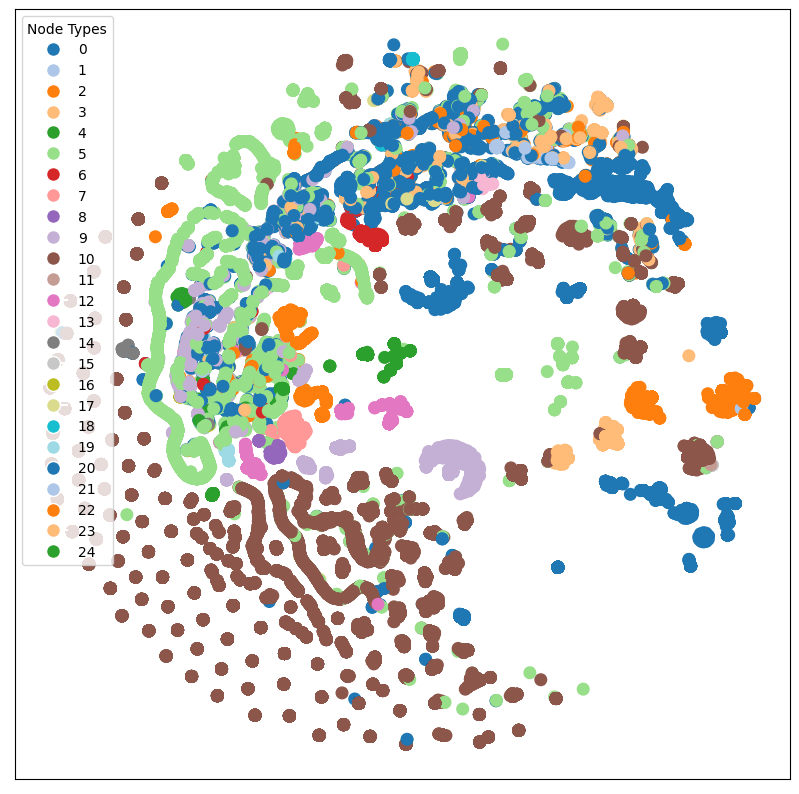

In [26]:
visualize(z,y)

In [ ]:
le = LabelEncoder()
y = le.fit_transform(nodes_df['type'])  # Convert the labels into numerical form

# Print the mapping of encoded values to original node types
print("Encoded Node Type Mapping:")
for i, node_type in enumerate(le.classes_):
    print(f"{i}: {node_type}")

Encoded Node Type Mapping:
0: Anatomy
1: Basic formal
2: Cell
3: Chemical
4: Chromosome
5: Disease
6: Environment
7: Environmental exposure
8: Food
9: GO
10: Gene
11: General medical science
12: Human developmental stage
13: Medical action
14: Mental disease
15: Mental functioning
16: Mouse pathology
17: NCI thesaurus
18: Neuro behaviour
19: Phenotype
20: Protein
21: Sequence
22: Species
23: Vaccine
24: miRNA


In [27]:
len(nodes_df[nodes_df['type'] == 'miRNA'])


4565

In [28]:
torch.save(model, view_path+'GATConv_model_view'+str(view)+'.pth')

In [29]:
import os

# Define the directory and file path
view =3
view_path = f'/home/khushboo/'
predictions_path = os.path.join(view_path, 'predictions')
file_path = os.path.join(predictions_path, f'view{view}_GATConv_node_embeddings.csv')

# Ensure the directory exists
os.makedirs(predictions_path, exist_ok=True)

In [30]:
probs = edges_to_predict_filtered.copy()
probs['probability']=get_prob(external_test_data)
probs.to_csv(view_path+'predictions/view'+str(view)+'_GATConv_node_embeddings.csv')

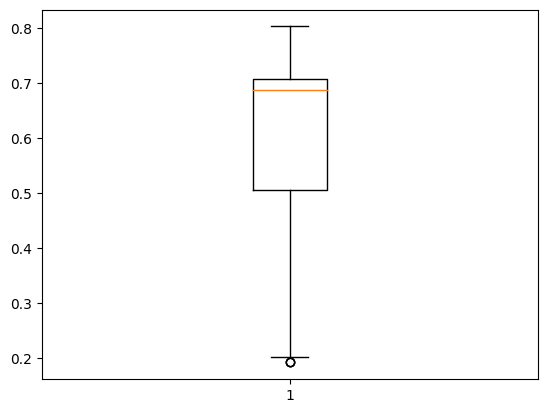

In [31]:
_=plt.boxplot(get_prob(test_data))

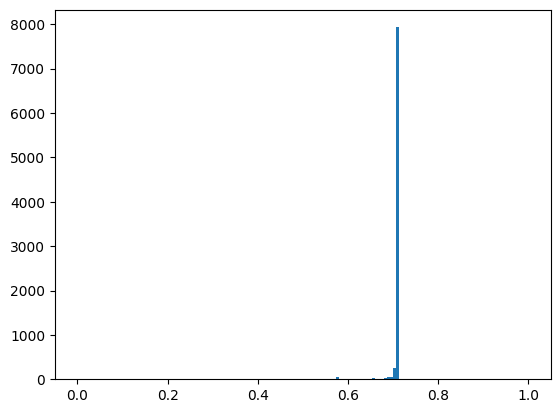

In [32]:
_=plt.hist(get_prob(external_test_data), bins=150, range=[0,1])

In [33]:
nodes_df

,name,type
0,<http://purl.obolibrary.org/obo/HP_0010945>,Phenotype
1,<https://www.mirbase.org/mature/MIMAT0027026>,miRNA
2,<http://purl.obolibrary.org/obo/MONDO_0000996>,Disease
3,<http://purl.obolibrary.org/obo/UBERON_0003831>,Anatomy
4,<https://www.mirbase.org/hairpin/MI0031521>,miRNA
...,...,...
87352,<http://purl.obolibrary.org/obo/MONDO_0021636>,Disease
87353,<http://purl.obolibrary.org/obo/MONDO_0012749>,Disease
87354,<http://www.ncbi.nlm.nih.gov/gene/80099>,Gene
87355,<http://purl.obolibrary.org/obo/HP_0100788>,Phenotype


In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = z
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [36]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9607
Precision: 0.9605
Recall: 0.9607


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prepare the features and labels
X = z
y = true_labels

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9610805860805861
Classification Report:
                           precision    recall  f1-score   support

                  Anatomy       0.92      0.91      0.92      1772
                     Cell       0.86      0.84      0.85       364
                 Chemical       0.87      0.85      0.86       661
               Chromosome       0.95      0.95      0.95        93
                  Disease       0.97      0.97      0.97      7344
              Environment       0.98      0.88      0.93       141
   Environmental exposure       0.98      0.97      0.97       131
                     Food       0.98      1.00      0.99        50
                       GO       0.93      0.91      0.92      1169
                     Gene       0.98      0.99      0.99      5831
  General medical science       1.00      0.50      0.67         2
          Genomic feature       0.99      0.98      0.99       742
Human developmental stage       1.00      0.95      0.97        19
         

In [22]:
from grape import Graph
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [23]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [40]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=z,  # Use simplified embedding features
    smoke_test=False,
    enable_cache=False
)

In [41]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINE.csv"
results.to_csv(filename)

In [42]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,specificity,fall_out,prevalence,miss_rate,positive_likelyhood_ratio,recall,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.8,1.0,True,0.971337,0.028663,0.5,0.894572,3.678122,0.105428,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.8,1.0,True,0.971823,0.028177,0.5,0.934669,2.318642,0.065331,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.8,1.0,True,0.972758,0.027242,0.5,0.894931,3.856846,0.105069,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.8,1.0,True,0.972224,0.027776,0.5,0.935384,2.326306,0.064616,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.8,1.0,True,0.972204,0.027796,0.5,0.894791,3.785009,0.105209,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.8,1.0,True,0.972330,0.027670,0.5,0.935784,2.320749,0.064216,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.8,1.0,True,0.972600,0.027400,0.5,0.895237,3.823515,0.104763,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.8,1.0,True,0.972586,0.027414,0.5,0.935872,2.339201,0.064128,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.8,1.0,True,0.972467,0.027533,0.5,0.894687,3.825010,0.105313,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.8,1.0,True,0.972397,0.027603,0.5,0.935328,2.342964,0.064672,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None


In [24]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

# from grape.edge_prediction import KipfGCNEdgePrediction

# # Node Label prediction evaluation
from grape.node_label_prediction import node_label_prediction_evaluation
from grape.node_label_prediction import DecisionTreeNodeLabelPrediction, RandomForestNodeLabelPrediction, MLPNodeLabelPrediction, GradientBoostingNodeLabelPrediction#, PerceptronNodeLabelPrediction

In [25]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[DecisionTreeEdgePrediction()],
    number_of_holdouts=5,
    node_features=z,  # Use simplified embedding features
    smoke_test=False
)


In [26]:
results = evaluation
filename = "results_"+view_name+"_FirstOrderLINE_DesicionTree_gatconv.csv"
results.to_csv(filename)

In [27]:
# Separate train and test results
train_results = evaluation[evaluation['evaluation_mode'] == 'train']
test_results = evaluation[evaluation['evaluation_mode'] == 'test']

# Function to compute mean metrics for a given evaluation mode
def compute_mean_metrics(data):
    results = []
    for holdout in data['holdout_number'].unique():
        holdout_data = data[data['holdout_number'] == holdout]

        # Calculate mean values for metrics
        auc_score = holdout_data['auroc'].mean()
        precision = holdout_data['precision'].mean()
        recall = holdout_data['recall'].mean()
        f1_score = holdout_data['f1_score'].mean()
        accuracy = holdout_data['accuracy'].mean()  # Assuming 'accuracy' column exists

        # Append results for this holdout
        results.append({
            'Holdout': holdout,
            'AUC': auc_score,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Accuracy': accuracy
        })

    # Convert to DataFrame
    return pd.DataFrame(results)

# Compute metrics for train and test
train_metrics_df = compute_mean_metrics(train_results)
test_metrics_df = compute_mean_metrics(test_results)

# Calculate overall mean for train and test
overall_train_mean = train_metrics_df.mean(numeric_only=True)
overall_test_mean = test_metrics_df.mean(numeric_only=True)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Evaluation Mode': ['Train', 'Test'],
    'AUC': [overall_train_mean['AUC'], overall_test_mean['AUC']],
    'Precision': [overall_train_mean['Precision'], overall_test_mean['Precision']],
    'Recall': [overall_train_mean['Recall'], overall_test_mean['Recall']],
    'F1 Score': [overall_train_mean['F1 Score'], overall_test_mean['F1 Score']],
    'Accuracy': [overall_train_mean['Accuracy'], overall_test_mean['Accuracy']]
})

# Display the summary of mean metrics
print(summary_df)


  Evaluation Mode       AUC  Precision    Recall  F1 Score  Accuracy
0           Train  0.887848   0.661761  0.107312  0.184673  0.526219
1            Test  0.885412   0.548760  0.066475  0.118584  0.505895


In [28]:
test_results = evaluation[evaluation['evaluation_mode'] == 'test']

# Check if the filtering worked
print(test_results)

# List to store metrics for plotting
results = []

# Loop through each holdout for test results
for holdout in test_results['holdout_number'].unique():
    # Extract metrics for this holdout
    holdout_data = test_results[test_results['holdout_number'] == holdout]
    
    # Calculate mean values for the metrics
    auc_score = holdout_data['auroc'].mean()
    precision = holdout_data['precision'].mean()
    recall = holdout_data['recall'].mean()
    f1_score = holdout_data['f1_score'].mean()

    # Append results for this holdout
    results.append({
        'Holdout': holdout,
        'AUC': auc_score,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    })

# Create a DataFrame to summarize the filtered test results
results_df = pd.DataFrame(results)

# Print the results for test mode
print(results_df)

  evaluation_mode  train_size  validation_unbalance_rate  \
1            test         0.8                        1.0   
1            test         0.8                        1.0   
1            test         0.8                        1.0   
1            test         0.8                        1.0   
1            test         0.8                        1.0   

   use_scale_free_distribution  fowlkes_mallows_index  threat_score  \
1                         True               0.193932      0.064173   
1                         True               0.190374      0.062704   
1                         True               0.185327      0.061499   
1                         True               0.189623      0.062415   
1                         True               0.195707      0.064361   

   negative_predictive_value  matthews_correlation_coefficient  specificity  \
1                   0.503629                          0.028522     0.945995   
1                   0.503088                          

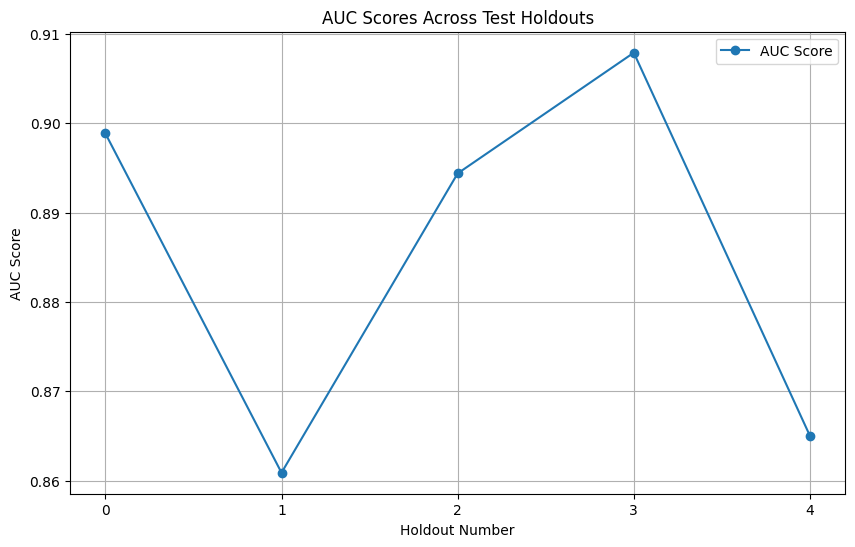

In [29]:
# Plotting AUC Scores for test mode
plt.figure(figsize=(10, 6))
plt.plot(results_df['Holdout'], results_df['AUC'], marker='o', label='AUC Score')
plt.title('AUC Scores Across Test Holdouts')
plt.xlabel('Holdout Number')
plt.ylabel('AUC Score')
plt.xticks(results_df['Holdout'])
plt.grid()
plt.legend()
plt.show()
